 # Лабораторная работа №5 Проведение исследований с градиентным бустингом


## 2. Создание бейзлайна и оценка качества

In [32]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

import seaborn as sns
import matplotlib.pyplot as plt


### Классификация

In [2]:
df = pd.read_csv(
    "train.csv"
)

df.head()


/tmp/ipykernel_9529/4101760861.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


Предобработка.

In [3]:
drop_cols = [
    'ID',
    'Customer_ID',
    'Name',
    'SSN',
    'Month',
    'Credit_History_Age'
]

df = df.drop(columns=drop_cols)

num_as_obj = [
    'Age',
    'Annual_Income',
    'Num_of_Loan',
    'Num_of_Delayed_Payment',
    'Changed_Credit_Limit',
    'Outstanding_Debt',
    'Amount_invested_monthly',
    'Monthly_Balance'
]

for col in num_as_obj:
    df[col] = pd.to_numeric(df[col], errors='coerce')

num_cols = df.select_dtypes(include=['int64', 'float64']).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median())

cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

Берем 20000 строк как в 1 лабораторной.

In [6]:
sample_size = 20000
df_sample = df.sample(n=sample_size, random_state=42)

X = df_sample.drop('Credit_Score', axis=1)
y = df_sample['Credit_Score']


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)




Создаем пайплайн и обучаем.

In [11]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

gb_pipeline = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            random_state=42
        ))
    ]
)


In [12]:
gb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount',
       'Payment_Behaviour'],
      dtype='object'))])),
                ('model', GradientBoostingClassifier(random_state=42))])

In [13]:
y_pred = gb_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.692
              precision    recall  f1-score   support

        Good       0.57      0.62      0.59       705
        Poor       0.74      0.62      0.68      1175
    Standard       0.71      0.75      0.73      2120

    accuracy                           0.69      4000
   macro avg       0.67      0.67      0.67      4000
weighted avg       0.70      0.69      0.69      4000



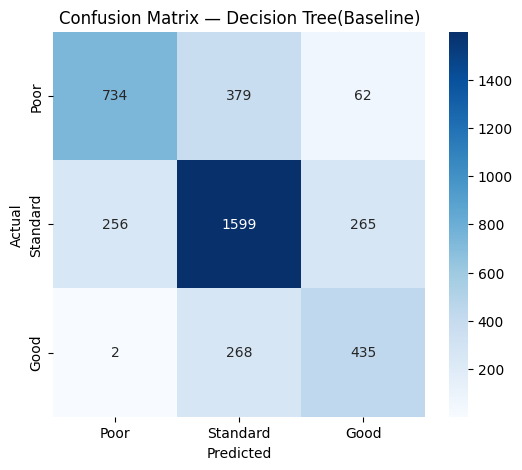

In [14]:
cm = confusion_matrix(y_test, y_pred, labels=['Poor', 'Standard', 'Good'])

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Poor', 'Standard', 'Good'],
    yticklabels=['Poor', 'Standard', 'Good']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix — Decision Tree(Baseline)')
plt.show()


Неплохой результат, но хуже, чем в последних лабах.

### Регрессия

In [28]:
df_reg = pd.read_csv(
    "vestiaire_20k.csv"
)

df_reg.head()

,product_id,product_type,product_name,product_description,product_keywords,product_gender_target,product_category,product_season,product_condition,product_like_count,...,warehouse_name,seller_id,seller_username,usually_ships_within,seller_country,seller_products_sold,seller_num_products_listed,seller_community_rank,seller_num_followers,seller_pass_rate
0,42438630,Wool hat,Wool hat Napapijri Black size 55 cm in Wool,"one size, like new",Napapijri Wool Hats & pull on hats,Men,Men Accessories,Autumn / Winter,Never worn,0.0,...,Tourcoing,25355068,Raffaele25355068,1-2 days,Italy,11.0,27.0,0.0,131.0,100.0
1,30324738,Leather flats,Leather flats Bruno Magli Black size 43.5 EU i...,"Excellent condition! UK size 9.5, EU 43.5",Bruno Magli Leather Flats,Men,Men Shoes,All seasons,Very good condition,6.0,...,Tourcoing,12877585,stelios12877585,NaN,Greece,5.0,2.0,649116.0,5.0,100.0
2,39089334,Polo shirt,Polo shirt LA MARTINA Multicolour size XXL Int...,"La Martina long sleeve polo shirt, size XXL in...",LA MARTINA Cotton Polo shirts,Men,Men Clothing,All seasons,Good condition,2.0,...,Tourcoing,21283960,anneanna21283960,1-2 days,Germany,132.0,90.0,0.0,25.0,95.0
3,39285681,Scarf,Scarf Twinset White in Cotton,Lightweight cotton scarf. White color with 2 h...,Twinset Cotton Scarves,Women,Women Accessories,Autumn / Winter,Very good condition,7.0,...,Tourcoing,15273943,bianca15273943,3-5 days,Italy,5.0,38.0,0.0,7.0,100.0
4,41107394,Leather low trainers,Leather low trainers Tod's Blue size 9.5 UK in...,"Iconic Tod's shoe, dark blue color. Mix suede ...",Tod's Leather Trainers,Men,Men Shoes,All seasons,Good condition,3.0,...,Tourcoing,19395265,Nicchia_20,6-7 days,Italy,4.0,15.0,0.0,163.0,100.0


Предобработка.

In [29]:
drop_cols = [
    'product_id', 'product_name', 'product_description', 'brand_url',
    'seller_username', 'brand_name', 'product_keywords', 'seller_id', 'brand_id', 'seller_price' , 'seller_country'
]


df_reg = df_reg.drop(columns=drop_cols)

df_reg = df_reg.dropna(subset=[
    'product_category', 'has_cross_border_fees', 'usually_ships_within'
])

Создание пайплайна и обучение.

In [30]:
df_reg_sample = df_reg

X_sample = df_reg_sample.drop('price_usd', axis=1)
y_sample = df_reg_sample['price_usd']

num_cols = X_sample.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_sample.select_dtypes(include=['object', 'bool']).columns

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

In [33]:
gb_reg_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            random_state=42
        ))
    ]
)

In [34]:
gb_reg_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['product_like_count', 'seller_earning', 'buyers_fees',
       'seller_products_sold', 'seller_num_products_listed',
       'seller_community_rank', 'seller_num_followers', 'seller_pass_rate'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['product_type', 'product_gender_target', 'product_category',
       'product_season', 'product_condition', 'sold', 'reserved', 'available',
       'in_stock', 'should_be_gone', 'product_material', 'product_color',
       'seller_badge', 'has_cross_border_fees', 'warehouse_name',
       'usually_ships_within'],
      dtype='object'))])),
                ('model', GradientBoostingRegressor(random_state=42))])

In [35]:
y_pred = gb_reg_pipeline.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))



MAE: 21.32923636334552
RMSE: 423.54719956158027
R2: 0.8494043725721329


Не очень впечатляющий результат по RMSE и R2, но MAE довольно низкая.

## 3. Улучшение бейзлайна

### Классификация

In [15]:
df = pd.read_csv(
    "train.csv"
)

df.head()

/tmp/ipykernel_9529/3975237315.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


Делаем первичную предобработку.

In [16]:
drop_cols = [
    'ID',
    'Customer_ID',
    'Name',
    'SSN',
    'Month',
    'Credit_History_Age'
]

df = df.drop(columns=drop_cols)

num_as_obj = [
    'Age',
    'Annual_Income',
    'Num_of_Loan',
    'Num_of_Delayed_Payment',
    'Changed_Credit_Limit',
    'Outstanding_Debt',
    'Amount_invested_monthly',
    'Monthly_Balance'
]

for col in num_as_obj:
    df[col] = pd.to_numeric(df[col], errors='coerce')

num_cols = df.select_dtypes(include=['int64', 'float64']).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median())

cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

Вспомним про гипотезу из первой лабораторной о том, что правильное распределение классов может помочь улучшить качество модели.

In [17]:
print(df['Credit_Score'].value_counts())

sample_size_per_class = 20000 // df['Credit_Score'].nunique()

df_sample = (
    df.groupby('Credit_Score', group_keys=False)
      .apply(lambda x: x.sample(min(len(x), sample_size_per_class), random_state=42))
)

print(df_sample['Credit_Score'].value_counts())

Credit_Score
Standard    53174
Poor        28998
Good        17828
Name: count, dtype: int64
Credit_Score
Good        6666
Poor        6666
Standard    6666
Name: count, dtype: int64


/tmp/ipykernel_9529/422736674.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), sample_size_per_class), random_state=42))


In [18]:
X_sample = df_sample.drop('Credit_Score', axis=1)
y_sample = df_sample['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample,
    test_size=0.2,
    random_state=42,
    stratify=y_sample
)

In [19]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

gb_pipeline = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            random_state=42
        ))
    ]
)


In [20]:
gb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount',
       'Payment_Behaviour'],
      dtype='object'))])),
                ('model', GradientBoostingClassifier(random_state=42))])

In [21]:
y_pred = gb_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.71325
              precision    recall  f1-score   support

        Good       0.69      0.84      0.76      1333
        Poor       0.75      0.76      0.76      1333
    Standard       0.70      0.54      0.61      1334

    accuracy                           0.71      4000
   macro avg       0.71      0.71      0.71      4000
weighted avg       0.71      0.71      0.71      4000



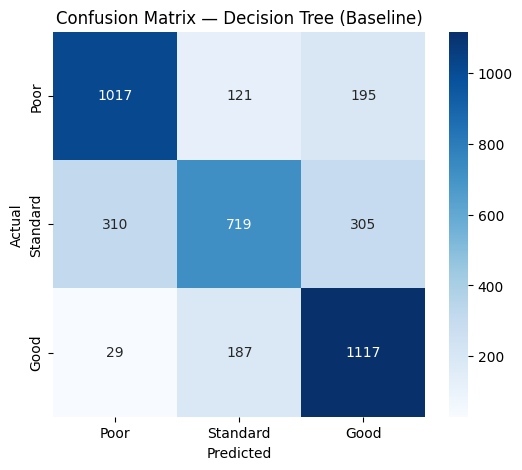

In [22]:
cm = confusion_matrix(y_test, y_pred, labels=['Poor', 'Standard', 'Good'])

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Poor', 'Standard', 'Good'],
    yticklabels=['Poor', 'Standard', 'Good']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix — Decision Tree (Baseline)')
plt.show()


Получили хороший прирост в качестве. Продолжаем анализ.

In [23]:
df = pd.read_csv(
    "train.csv"
)

df.head()

/tmp/ipykernel_9529/3975237315.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


Создадим числовой признак из `Credit_History_Age`.

In [24]:
import re

def convert_credit_history(age_str):
    if pd.isna(age_str):
        return None
    match = re.match(r'(\d+)\s*Years\s*and\s*(\d+)?\s*Months', age_str)
    if match:
        years = int(match.group(1))
        months = int(match.group(2)) if match.group(2) else 0
        return years + months / 12
    else:
        return None

df['Credit_History_Age_num'] = df['Credit_History_Age'].apply(convert_credit_history)

df[['Credit_History_Age', 'Credit_History_Age_num']].head()

num_as_obj = [
    'Age',
    'Annual_Income',
    'Num_of_Loan',
    'Num_of_Delayed_Payment',
    'Changed_Credit_Limit',
    'Outstanding_Debt',
    'Amount_invested_monthly',
    'Monthly_Balance'
]

for col in num_as_obj:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# df = df[(df['Credit_History_Age_num'].between(0, 100))]

# df = df[(df['Age'].between(0, 100))]

drop_cols = [
    'ID',
    'Customer_ID',
    'Name',
    'SSN',
    'Month',
    'Credit_History_Age'
]

df = df.drop(columns=drop_cols)

num_cols = df.select_dtypes(include=['int64', 'float64']).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median())

cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [25]:
print(df['Credit_Score'].value_counts())

sample_size_per_class = 20000 // df['Credit_Score'].nunique()

df_sample = (
    df.groupby('Credit_Score', group_keys=False)
      .apply(lambda x: x.sample(min(len(x), sample_size_per_class), random_state=42))
)

print(df_sample['Credit_Score'].value_counts())

Credit_Score
Standard    53174
Poor        28998
Good        17828
Name: count, dtype: int64
Credit_Score
Good        6666
Poor        6666
Standard    6666
Name: count, dtype: int64


/tmp/ipykernel_9529/422736674.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), sample_size_per_class), random_state=42))


In [26]:
X_sample = df_sample.drop('Credit_Score', axis=1)
y_sample = df_sample['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample,
    test_size=0.2,
    random_state=42,
    stratify=y_sample
)

In [27]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

gb_pipeline = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            random_state=42
        ))
    ]
)

In [28]:
gb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount',
       'Payment_Behaviour'],
      dtype='object'))])),
                ('model', GradientBoostingClassifier(random_state=42))])

In [29]:
y_pred = gb_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.71325
              precision    recall  f1-score   support

        Good       0.69      0.84      0.76      1333
        Poor       0.75      0.76      0.76      1333
    Standard       0.70      0.54      0.61      1334

    accuracy                           0.71      4000
   macro avg       0.71      0.71      0.71      4000
weighted avg       0.71      0.71      0.71      4000



Никакого улучшения. Попробуем обработать Age и Credit_History_Age.

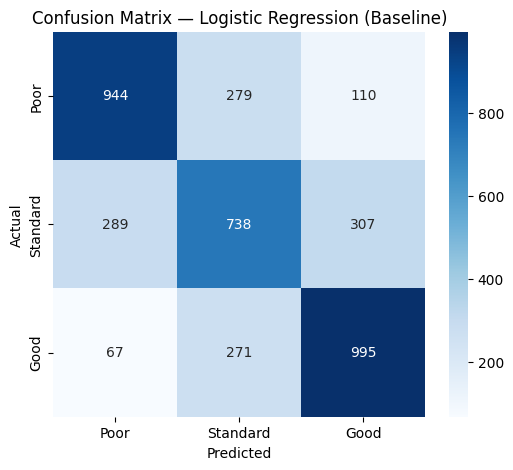

In [26]:
cm = confusion_matrix(y_test, y_pred, labels=['Poor', 'Standard', 'Good'])

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Poor', 'Standard', 'Good'],
    yticklabels=['Poor', 'Standard', 'Good']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix — Logistic Regression (Baseline)')
plt.show()


In [2]:
df = pd.read_csv(
    "train.csv"
)

df.head()

/tmp/ipykernel_3272/3975237315.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [3]:
import re

def convert_credit_history(age_str):
    if pd.isna(age_str):
        return None
    match = re.match(r'(\d+)\s*Years\s*and\s*(\d+)?\s*Months', age_str)
    if match:
        years = int(match.group(1))
        months = int(match.group(2)) if match.group(2) else 0
        return years + months / 12
    else:
        return None

df['Credit_History_Age_num'] = df['Credit_History_Age'].apply(convert_credit_history)

df[['Credit_History_Age', 'Credit_History_Age_num']].head()

num_as_obj = [
    'Age',
    'Annual_Income',
    'Num_of_Loan',
    'Num_of_Delayed_Payment',
    'Changed_Credit_Limit',
    'Outstanding_Debt',
    'Amount_invested_monthly',
    'Monthly_Balance'
]

for col in num_as_obj:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df[(df['Credit_History_Age_num'].between(0, 100))]

df = df[(df['Age'].between(0, 100))]


drop_cols = [
    'ID',
    'Customer_ID',
    'Name',
    'SSN',
    'Month',
    'Credit_History_Age'
]

df = df.drop(columns=drop_cols)

num_cols = df.select_dtypes(include=['int64', 'float64']).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median())

cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [4]:
print(df['Credit_Score'].value_counts())

sample_size_per_class = 20000 // df['Credit_Score'].nunique()

df_sample = (
    df.groupby('Credit_Score', group_keys=False)
      .apply(lambda x: x.sample(min(len(x), sample_size_per_class), random_state=42))
)

print(df_sample['Credit_Score'].value_counts())

Credit_Score
Standard    44748
Poor        24401
Good        14882
Name: count, dtype: int64
Credit_Score
Good        6666
Poor        6666
Standard    6666
Name: count, dtype: int64


/tmp/ipykernel_3272/422736674.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), sample_size_per_class), random_state=42))


In [5]:
X_sample = df_sample.drop('Credit_Score', axis=1)
y_sample = df_sample['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample,
    test_size=0.2,
    random_state=42,
    stratify=y_sample
)

In [6]:
num_cols = X_sample.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_sample.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

gb_pipeline = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            random_state=42
        ))
    ]
)

In [7]:
gb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance',
       'Credit_History_Age_num'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount',
       'Payment_Behaviour'],
      dtype='object'))])),
                ('model', GradientBoostingClassifier(random_state=42))])

In [8]:
y_pred = gb_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7215
              precision    recall  f1-score   support

        Good       0.71      0.84      0.77      1333
        Poor       0.75      0.77      0.76      1333
    Standard       0.71      0.55      0.62      1334

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.72      0.72      0.72      4000



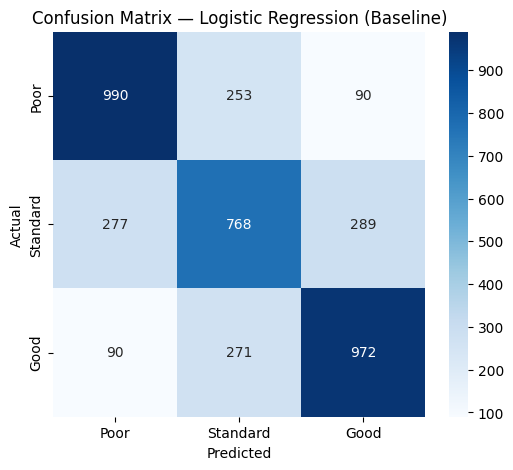

In [13]:
cm = confusion_matrix(y_test, y_pred, labels=['Poor', 'Standard', 'Good'])

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Poor', 'Standard', 'Good'],
    yticklabels=['Poor', 'Standard', 'Good']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix — Logistic Regression (Baseline)')
plt.show()


Результат улучшился.

In [11]:
param_grid = {
    'model__n_estimators': [50, 80],
    'model__learning_rate': [0.01, 0.1],
    'model__max_depth': [3, 4]

}


grid_search = GridSearchCV(
    estimator=gb_pipeline,
    param_grid=param_grid,
    cv=3,  
    scoring='accuracy',
    n_jobs=-1, 
    verbose=1,  
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
y_pred_best = grid_search.best_estimator_.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 80}
Accuracy: 0.72975
              precision    recall  f1-score   support

        Good       0.72      0.85      0.78      1333
        Poor       0.75      0.78      0.77      1333
    Standard       0.72      0.56      0.63      1334

    accuracy                           0.73      4000
   macro avg       0.73      0.73      0.72      4000
weighted avg       0.73      0.73      0.72      4000



Лучшие параметры: `{'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 80}`. Результат для классификации хороший, но не лучший.

### Регрессия

In [36]:
df_reg = pd.read_csv(
    "vestiaire_20k.csv"
)

df_reg.head()

,product_id,product_type,product_name,product_description,product_keywords,product_gender_target,product_category,product_season,product_condition,product_like_count,...,warehouse_name,seller_id,seller_username,usually_ships_within,seller_country,seller_products_sold,seller_num_products_listed,seller_community_rank,seller_num_followers,seller_pass_rate
0,42438630,Wool hat,Wool hat Napapijri Black size 55 cm in Wool,"one size, like new",Napapijri Wool Hats & pull on hats,Men,Men Accessories,Autumn / Winter,Never worn,0.0,...,Tourcoing,25355068,Raffaele25355068,1-2 days,Italy,11.0,27.0,0.0,131.0,100.0
1,30324738,Leather flats,Leather flats Bruno Magli Black size 43.5 EU i...,"Excellent condition! UK size 9.5, EU 43.5",Bruno Magli Leather Flats,Men,Men Shoes,All seasons,Very good condition,6.0,...,Tourcoing,12877585,stelios12877585,NaN,Greece,5.0,2.0,649116.0,5.0,100.0
2,39089334,Polo shirt,Polo shirt LA MARTINA Multicolour size XXL Int...,"La Martina long sleeve polo shirt, size XXL in...",LA MARTINA Cotton Polo shirts,Men,Men Clothing,All seasons,Good condition,2.0,...,Tourcoing,21283960,anneanna21283960,1-2 days,Germany,132.0,90.0,0.0,25.0,95.0
3,39285681,Scarf,Scarf Twinset White in Cotton,Lightweight cotton scarf. White color with 2 h...,Twinset Cotton Scarves,Women,Women Accessories,Autumn / Winter,Very good condition,7.0,...,Tourcoing,15273943,bianca15273943,3-5 days,Italy,5.0,38.0,0.0,7.0,100.0
4,41107394,Leather low trainers,Leather low trainers Tod's Blue size 9.5 UK in...,"Iconic Tod's shoe, dark blue color. Mix suede ...",Tod's Leather Trainers,Men,Men Shoes,All seasons,Good condition,3.0,...,Tourcoing,19395265,Nicchia_20,6-7 days,Italy,4.0,15.0,0.0,163.0,100.0


In [37]:
drop_cols = [
    'product_id', 'product_name', 'product_description', 'brand_url',
    'seller_username', 'brand_name', 'product_keywords', 'seller_id', 'brand_id', 'seller_price' , 'seller_country'
]


df_reg = df_reg.drop(columns=drop_cols)

df_reg = df_reg.dropna(subset=[
    'product_category', 'has_cross_border_fees', 'usually_ships_within'
])

In [39]:
sample_size = 10000
df_sample = df_reg.sample(n=sample_size, random_state=42)

X_sample = df_sample.drop('price_usd', axis=1)
y_sample = df_sample['price_usd']

num_cols = X_sample.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_sample.select_dtypes(include=['object', 'bool']).columns

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

In [40]:
param_grid = {
    'model__n_estimators': [50, 80],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [2, 3, 4],
    'model__subsample': [0.8, 1.0] 
}

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,               
    scoring='r2',       
    n_jobs=-1,          
    verbose=1
)

grid_search.fit(X_train, y_train)



Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['product_like_count', 'seller_earning', 'buyers_fees',
       'seller_products_sold', 'seller_num_products_listed',
       'seller_community_rank', 'seller_num_followers', 'seller_pass_rate'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ig...
       'in_stock', 'should_be_gone', 'product_material', 'product_color',
       'seller_badge', 'has_cross_border_fees', 'warehouse_name',
       'usually_ships_within'],
      dtype='object'))])),
                                       ('model',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [2, 3, 4],
                         'model__n_estimators': [50, 80],
                         'model__subsample': [0.8, 1.0]},
             scoring='r2', verbose=1)

In [42]:
print("Best parameters:")
print(grid_search.best_params_)

best_tree = grid_search.best_estimator_

y_pred_best = best_tree.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred_best))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("R2:", r2_score(y_test, y_pred_best))


Best parameters:
{'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 80, 'model__subsample': 0.8}
MAE: 21.923068800011784
RMSE: 345.3702312156018
R2: 0.9489845808930376


Хороший результат. Подбор параметров помог сильно улучшить метрики, однако пришлось урезать данные. RMSE, однако, довольно велико. 

Пробуем удалить product_type.

In [45]:
drop_cols = ['product_type']

df_reg_sample_n = df_sample.drop(columns=drop_cols)

In [46]:
X_sample = df_reg_sample_n.drop('price_usd', axis=1)
y_sample = df_reg_sample_n['price_usd']

num_cols = X_sample.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_sample.select_dtypes(include=['object', 'bool']).columns

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

In [47]:
param_grid = {
    'model__n_estimators': [50, 80],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [2, 3, 4],
    'model__subsample': [0.8, 1.0] 
}

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,               
    scoring='r2',       
    n_jobs=-1,          
    verbose=1
)

grid_search.fit(X_train, y_train)



Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['product_like_count', 'seller_earning', 'buyers_fees',
       'seller_products_sold', 'seller_num_products_listed',
       'seller_community_rank', 'seller_num_followers', 'seller_pass_rate'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ig...
       'should_be_gone', 'product_material', 'product_color', 'seller_badge',
       'has_cross_border_fees', 'warehouse_name', 'usually_ships_within'],
      dtype='object'))])),
                                       ('model',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [2, 3, 4],
                         'model__n_estimators': [50, 80],
                         'model__subsample': [0.8, 1.0]},
             scoring='r2', verbose=1)

In [48]:
print("Best parameters:")
print(grid_search.best_params_)

best_tree = grid_search.best_estimator_

y_pred_best = best_tree.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred_best))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("R2:", r2_score(y_test, y_pred_best))


Best parameters:
{'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 80, 'model__subsample': 0.8}
MAE: 25.44012937397988
RMSE: 465.0869523372378
R2: 0.9074875957031406


Улучшений нет.

## 4. Имплементация алгоритма машинного обучения 

### Классификация.

In [12]:
class CustomGradientBoostingClassifier:
    def __init__(
        self,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state

        self.trees = []
        self.n_classes = None
        self.classes_ = None
        self.label_encoder = LabelEncoder()

    @staticmethod
    def _softmax(z):
        z = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y):
        y_encoded = self.label_encoder.fit_transform(y)
        self.classes_ = self.label_encoder.classes_
        self.n_classes = len(self.classes_)

        n_samples = X.shape[0]

        Y = np.zeros((n_samples, self.n_classes))
        Y[np.arange(n_samples), y_encoded] = 1

        F = np.zeros((n_samples, self.n_classes))

        self.trees = []

        for m in range(self.n_estimators):
            P = self._softmax(F)
            trees_m = []

            for k in range(self.n_classes):
                residual = Y[:, k] - P[:, k]

                tree = DecisionTreeRegressor(
                    max_depth=self.max_depth,
                    random_state=self.random_state
                )
                tree.fit(X, residual)

                F[:, k] += self.learning_rate * tree.predict(X)
                trees_m.append(tree)

            self.trees.append(trees_m)

        return self

    def predict_proba(self, X):
        n_samples = X.shape[0]
        F = np.zeros((n_samples, self.n_classes))

        for trees_m in self.trees:
            for k, tree in enumerate(trees_m):
                F[:, k] += self.learning_rate * tree.predict(X)

        return self._softmax(F)

    def predict(self, X):
        proba = self.predict_proba(X)
        class_idx = np.argmax(proba, axis=1)
        return self.label_encoder.inverse_transform(class_idx)


In [13]:
df = pd.read_csv(
    "train.csv"
)

df.head()

/tmp/ipykernel_3272/3975237315.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


Простая предобработка.

In [14]:
drop_cols = [
    'ID',
    'Customer_ID',
    'Name',
    'SSN',
    'Month',
    'Credit_History_Age'
]

df = df.drop(columns=drop_cols)

num_as_obj = [
    'Age',
    'Annual_Income',
    'Num_of_Loan',
    'Num_of_Delayed_Payment',
    'Changed_Credit_Limit',
    'Outstanding_Debt',
    'Amount_invested_monthly',
    'Monthly_Balance'
]

for col in num_as_obj:
    df[col] = pd.to_numeric(df[col], errors='coerce')

num_cols = df.select_dtypes(include=['int64', 'float64']).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median())

cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

Берем 20000 строк случайно.

In [18]:
sample_size = 10000
df_sample = df.sample(n=sample_size, random_state=42)

X = df_sample.drop('Credit_Score', axis=1)
y = df_sample['Credit_Score']

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'bool']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)


X_processed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y.values, test_size=0.2, random_state=42, stratify=y
)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [19]:
custom_gb = CustomGradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3
)

custom_gb.fit(X_train, y_train)  


In [21]:
y_pred = custom_gb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6755
              precision    recall  f1-score   support

        Good       0.55      0.66      0.60       350
        Poor       0.71      0.60      0.65       589
    Standard       0.71      0.72      0.72      1061

    accuracy                           0.68      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.68      0.68      0.68      2000



Результат хуже, чем в бейзлайне без улучшений. Анализируем дальше.

In [22]:
df = pd.read_csv(
    "train.csv"
)

df.head()

/tmp/ipykernel_3272/3975237315.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [23]:
import re

def convert_credit_history(age_str):
    if pd.isna(age_str):
        return None
    match = re.match(r'(\d+)\s*Years\s*and\s*(\d+)?\s*Months', age_str)
    if match:
        years = int(match.group(1))
        months = int(match.group(2)) if match.group(2) else 0
        return years + months / 12
    else:
        return None

df['Credit_History_Age_num'] = df['Credit_History_Age'].apply(convert_credit_history)

df[['Credit_History_Age', 'Credit_History_Age_num']].head()

num_as_obj = [
    'Age',
    'Annual_Income',
    'Num_of_Loan',
    'Num_of_Delayed_Payment',
    'Changed_Credit_Limit',
    'Outstanding_Debt',
    'Amount_invested_monthly',
    'Monthly_Balance'
]

for col in num_as_obj:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df[(df['Credit_History_Age_num'].between(0, 100))]

df = df[(df['Age'].between(0, 100))]


drop_cols = [
    'ID',
    'Customer_ID',
    'Name',
    'SSN',
    'Month',
    'Credit_History_Age'
]

df = df.drop(columns=drop_cols)

num_cols = df.select_dtypes(include=['int64', 'float64']).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median())

cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [24]:
print(df['Credit_Score'].value_counts())

sample_size_per_class = 10000 // df['Credit_Score'].nunique()

df_sample = (
    df.groupby('Credit_Score', group_keys=False)
      .apply(lambda x: x.sample(min(len(x), sample_size_per_class), random_state=42))
)

print(df_sample['Credit_Score'].value_counts())

Credit_Score
Standard    44748
Poor        24401
Good        14882
Name: count, dtype: int64
Credit_Score
Good        3333
Poor        3333
Standard    3333
Name: count, dtype: int64


/tmp/ipykernel_3272/2384795459.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), sample_size_per_class), random_state=42))


In [25]:
X = df_sample.drop('Credit_Score', axis=1)
y = df_sample['Credit_Score']

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'bool']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)


X_processed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y.values, test_size=0.2, random_state=42, stratify=y
)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


In [26]:
custom_gb = CustomGradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3
)

custom_gb.fit(X_train, y_train)  

In [27]:
y_pred = custom_gb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.71
              precision    recall  f1-score   support

        Good       0.68      0.84      0.75       666
        Poor       0.76      0.75      0.75       667
    Standard       0.70      0.55      0.61       667

    accuracy                           0.71      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.71      0.71      0.71      2000



По сравнению с предыдущим результатом работы моей реализации, это лучше, но sklearn выигрывает.

### Регрессия

In [49]:
class CustomGradientBoostingRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []
        self.init_pred = None

    def fit(self, X, y):
        self.init_pred = np.mean(y)
        F = np.full(y.shape, self.init_pred)
        self.trees = []

        for m in range(self.n_estimators):
            residual = y - F 
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X, residual)
            update = tree.predict(X)
            F += self.learning_rate * update
            self.trees.append(tree)
        return self

    def predict(self, X):
        F = np.full(X.shape[0], self.init_pred)
        for tree in self.trees:
            F += self.learning_rate * tree.predict(X)
        return F


In [50]:
df_reg = pd.read_csv(
    "vestiaire_20k.csv"
)

df_reg.head()

,product_id,product_type,product_name,product_description,product_keywords,product_gender_target,product_category,product_season,product_condition,product_like_count,...,warehouse_name,seller_id,seller_username,usually_ships_within,seller_country,seller_products_sold,seller_num_products_listed,seller_community_rank,seller_num_followers,seller_pass_rate
0,42438630,Wool hat,Wool hat Napapijri Black size 55 cm in Wool,"one size, like new",Napapijri Wool Hats & pull on hats,Men,Men Accessories,Autumn / Winter,Never worn,0.0,...,Tourcoing,25355068,Raffaele25355068,1-2 days,Italy,11.0,27.0,0.0,131.0,100.0
1,30324738,Leather flats,Leather flats Bruno Magli Black size 43.5 EU i...,"Excellent condition! UK size 9.5, EU 43.5",Bruno Magli Leather Flats,Men,Men Shoes,All seasons,Very good condition,6.0,...,Tourcoing,12877585,stelios12877585,NaN,Greece,5.0,2.0,649116.0,5.0,100.0
2,39089334,Polo shirt,Polo shirt LA MARTINA Multicolour size XXL Int...,"La Martina long sleeve polo shirt, size XXL in...",LA MARTINA Cotton Polo shirts,Men,Men Clothing,All seasons,Good condition,2.0,...,Tourcoing,21283960,anneanna21283960,1-2 days,Germany,132.0,90.0,0.0,25.0,95.0
3,39285681,Scarf,Scarf Twinset White in Cotton,Lightweight cotton scarf. White color with 2 h...,Twinset Cotton Scarves,Women,Women Accessories,Autumn / Winter,Very good condition,7.0,...,Tourcoing,15273943,bianca15273943,3-5 days,Italy,5.0,38.0,0.0,7.0,100.0
4,41107394,Leather low trainers,Leather low trainers Tod's Blue size 9.5 UK in...,"Iconic Tod's shoe, dark blue color. Mix suede ...",Tod's Leather Trainers,Men,Men Shoes,All seasons,Good condition,3.0,...,Tourcoing,19395265,Nicchia_20,6-7 days,Italy,4.0,15.0,0.0,163.0,100.0


Простая предобработка.

In [51]:
drop_cols = [
    'product_id', 'product_name', 'product_description', 'brand_url',
    'seller_username', 'brand_name', 'product_keywords', 'seller_id', 'brand_id', 'seller_price' , 'seller_country'
]


df_reg = df_reg.drop(columns=drop_cols)

df_reg = df_reg.dropna(subset=[
    'product_category', 'has_cross_border_fees', 'usually_ships_within'
])

In [52]:

df_reg_sample = df_reg

X_sample = df_reg_sample.drop('price_usd', axis=1)
y_sample = df_reg_sample['price_usd']

num_cols = X_sample.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_sample.select_dtypes(include=['object', 'bool']).columns

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [54]:
custom_gb = CustomGradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)

custom_gb.fit(X_train_scaled, y_train)


In [56]:
y_pred = custom_gb.predict(X_test_scaled)


print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))


MAE: 21.259395400222424
RMSE: 419.19397452422703
R2: 0.8524841126470054


Результат не впечатляет. Моя реализация решающего дерева оказалась хуже, чем sklearn.

In [59]:
drop_cols = ['product_type']

df_reg_sample_n = df_reg_sample.drop(columns=drop_cols)

In [60]:
X_sample = df_reg_sample_n.drop('price_usd', axis=1)
y_sample = df_reg_sample_n['price_usd']

num_cols = X_sample.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_sample.select_dtypes(include=['object', 'bool']).columns

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [61]:
custom_gb = CustomGradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)

custom_gb.fit(X_train_scaled, y_train)


In [62]:
y_pred = custom_gb.predict(X_test_scaled)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))


MAE: 23.49950943780613
RMSE: 564.0077600172342
R2: 0.7329584182575806


К сожалению, это не помогло улучшить результат.

### Вывод
Решающие деревья sklearn показали лучший результат в классификации, моя реализация не сильно отстала. С регрессией дела похуже: низкая MAE, но при этом высокая RMSE и R2 ниже, чем у линейной регрессии.

| Задача | Бейзлайн | Улучшенный бейзлайн | Моя реализация | Моя реализация улучшенная|
|----------|-------------------------|---------------------------|------------------------|---------------------------|
Классификация (Accuracy)| 0.692|**0.7298** | 0.6755| 0.71| |
Регрессия (R2)|0.8494|**0.9489**| 0.8524| 	0.8524| |